In [1]:
import pandas as pd
import os

In [2]:
r = 1

min_start_len = 5000*r
min_start_ratio = 0.8
max_merge_dist = 1000*r
dbscan_eps = 1000*r
min_len_after_split_strand = 1000*r
min_len_after_split_dbscan = 2000*r
min_len_after_split = 1000*r
graph_sim_ratio = 0.8

dset = 'part07_cattle'
res_dir = '../results_a4/' + dset + '/'
os.makedirs(res_dir, exist_ok=True)

# preprocessing

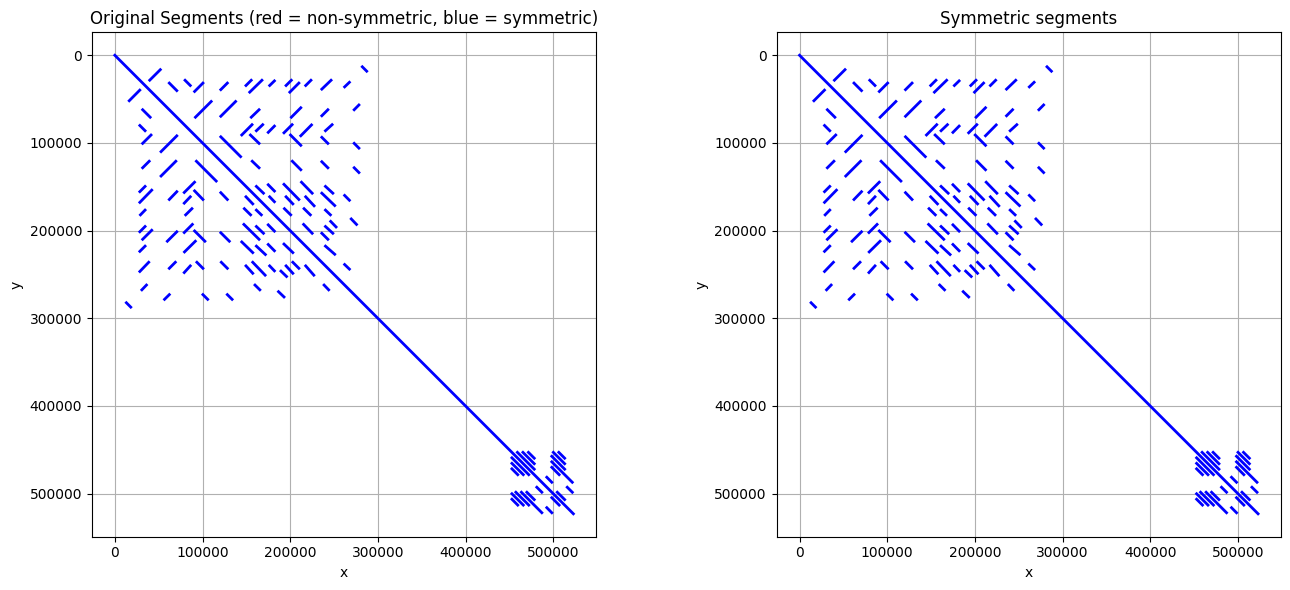

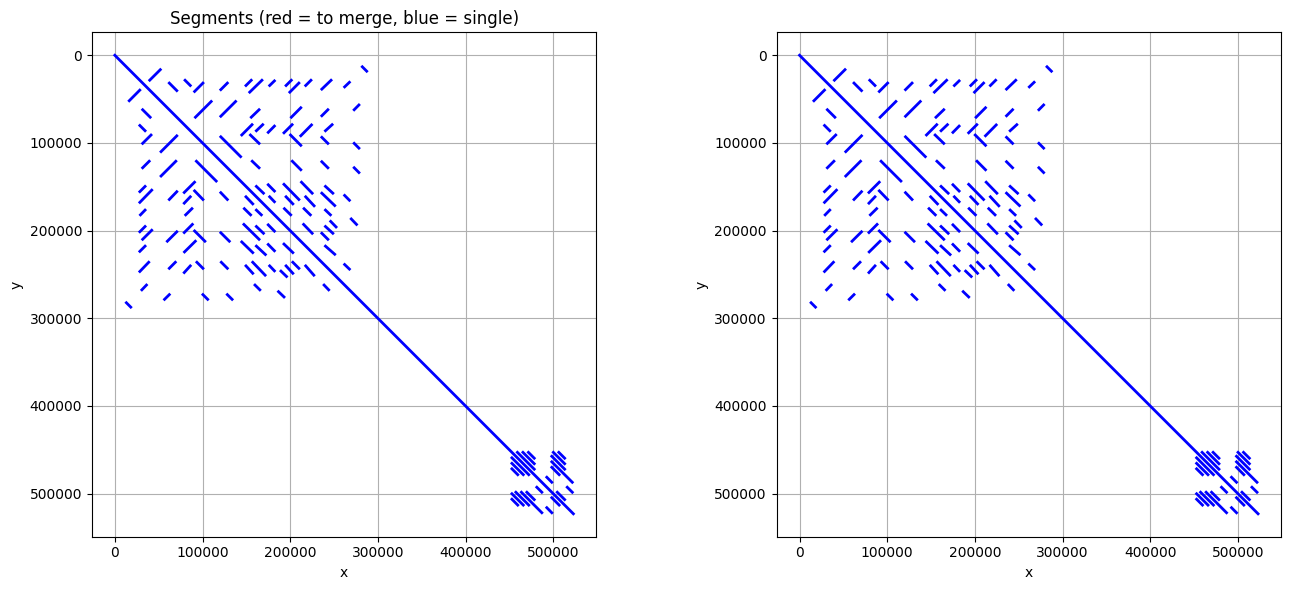

In [3]:
from importlib import reload

import utilx1
reload(utilx1)
from utilx1 import preprocess, merge_segments, symmetric

species_id = 0
species_name = 'cattle'

df1 = pd.read_csv('../a1_fasta/patchwork_output_cattl_part07/pairwise_alignments/self_0-cattle_IGL.tsv', sep='\t')
df2 = preprocess(df1, min_start_len, min_start_ratio)
df3 = symmetric(df2, plot=True)
df4 = merge_segments(df3, threshold=1000, plot=True)

# negative strands

0 : 133


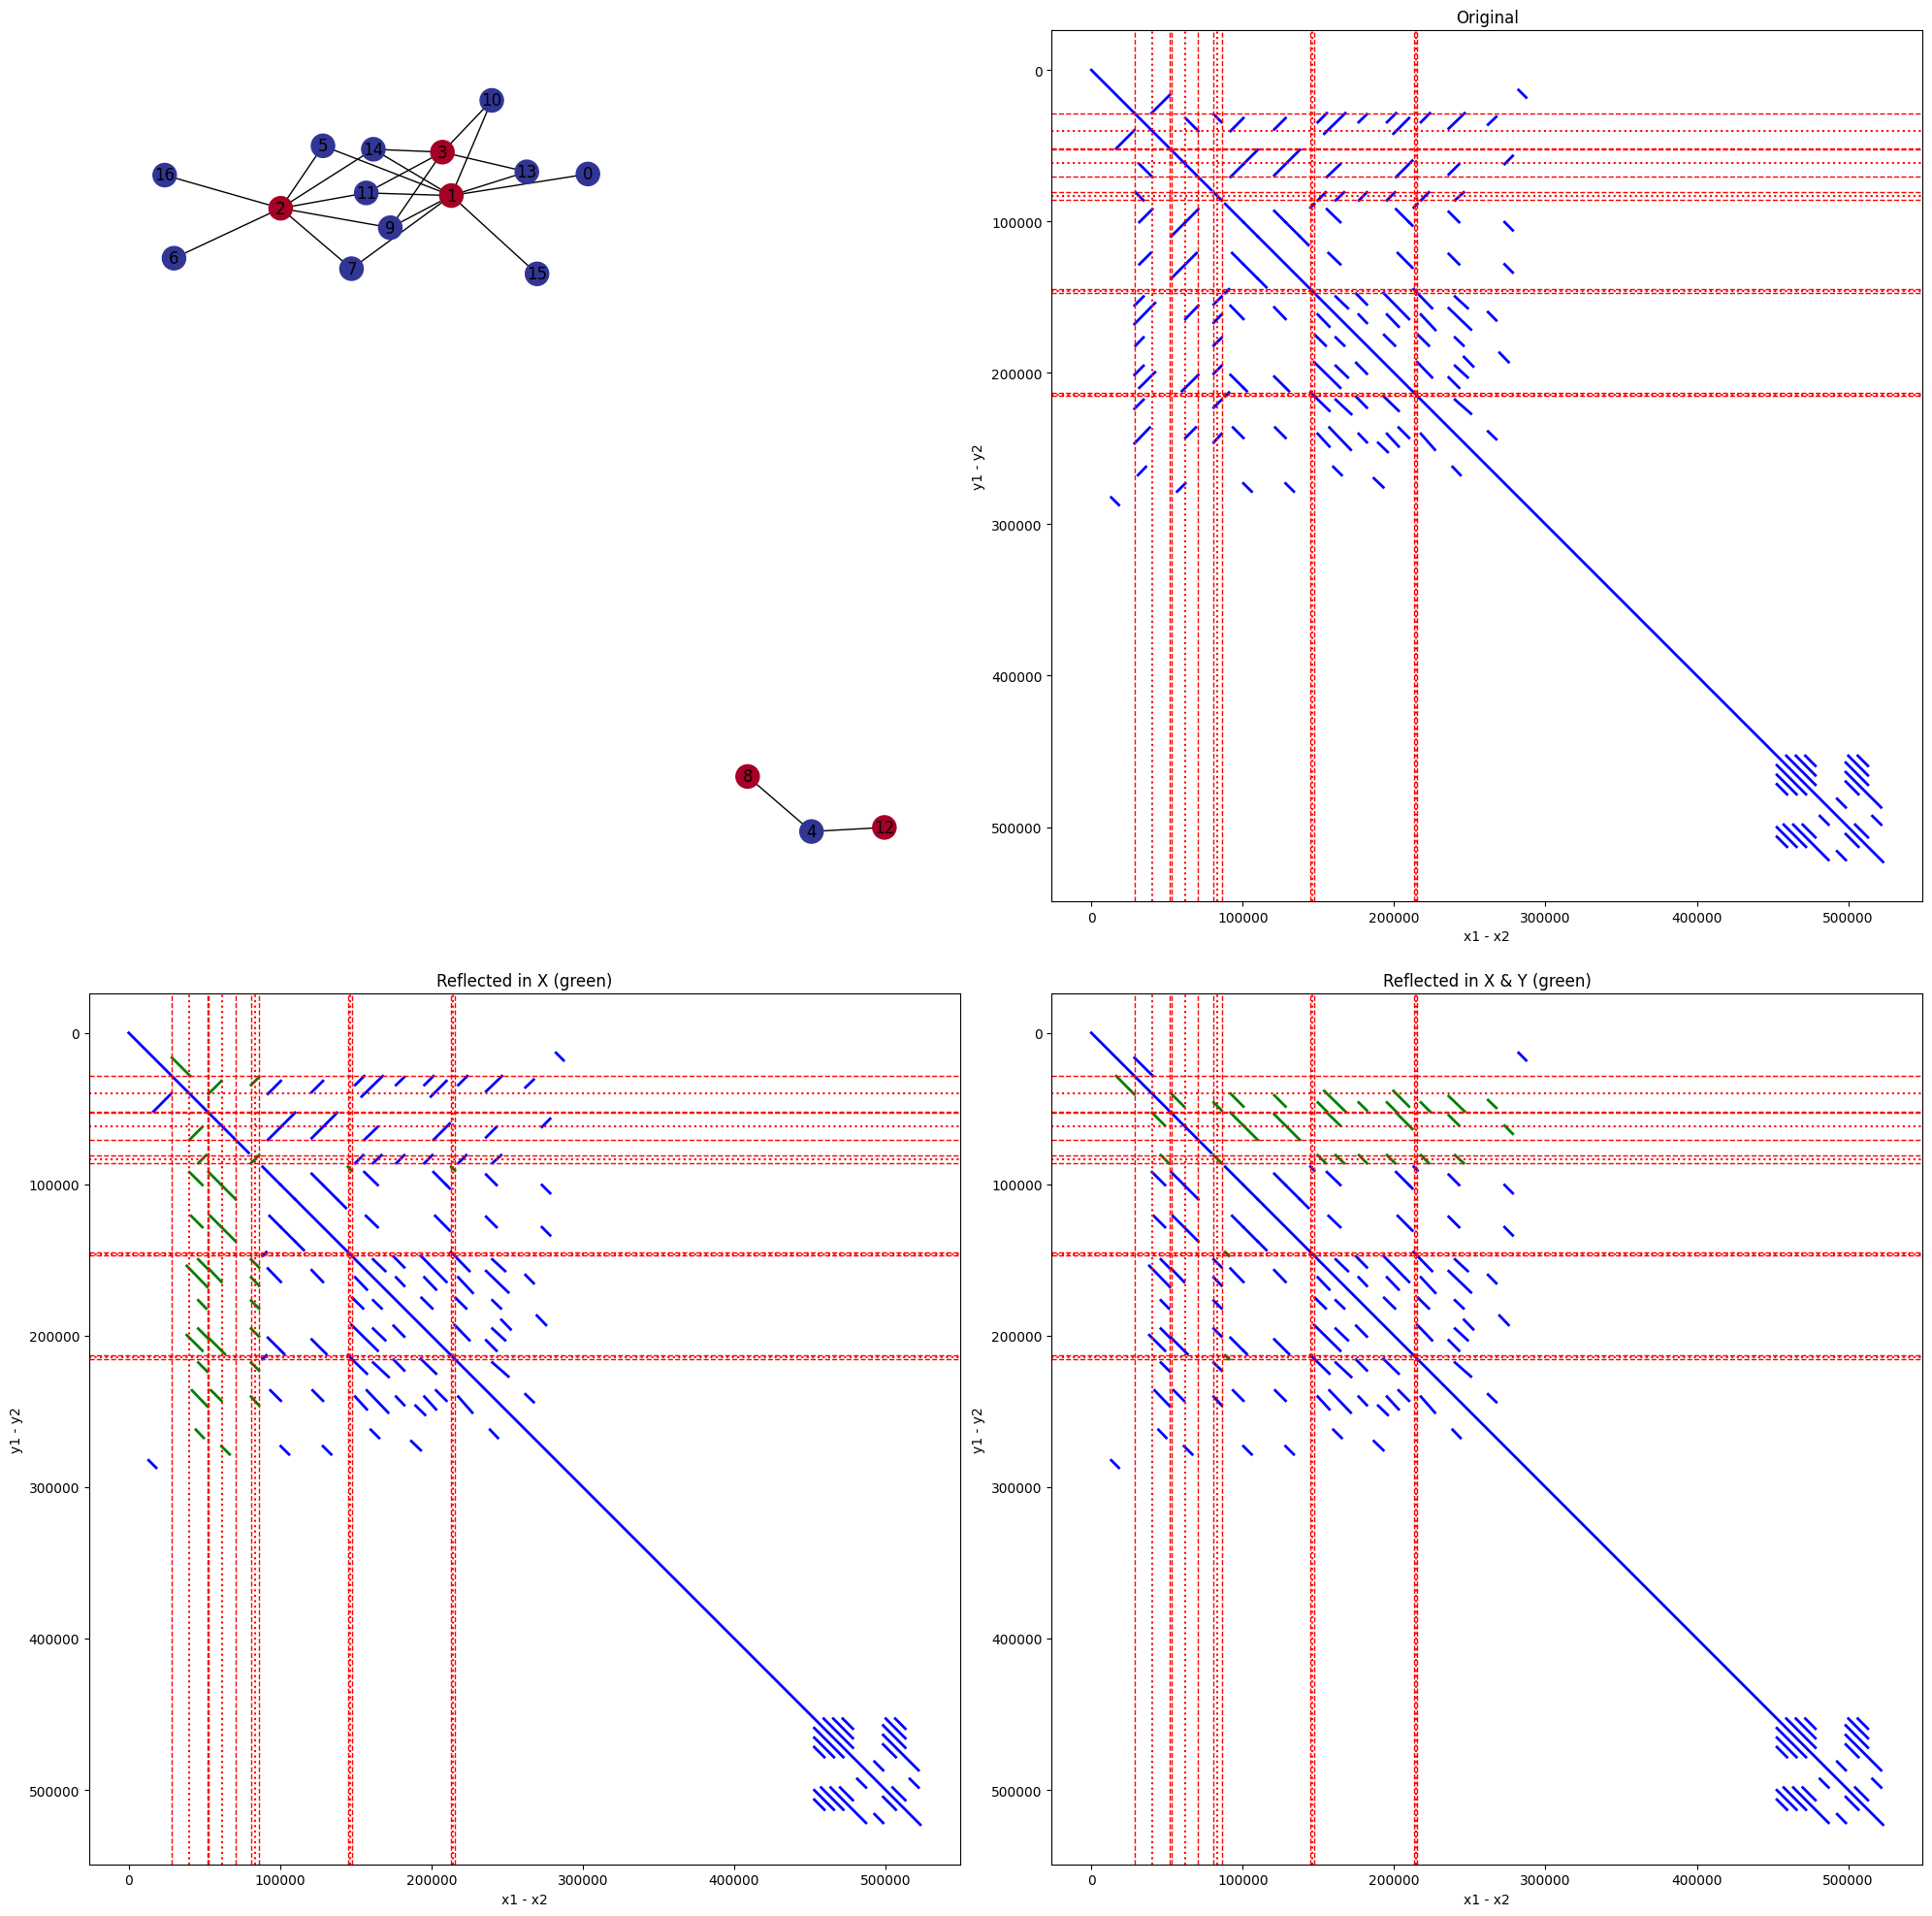

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

import utilx1
reload(utilx1)
from utilx1 import find_negative_sites, find_negative_set, reflect_segments_with_visuals

import utilx2
reload(utilx2)
from utilx2 import split_segments_by_values

df5, df5_sites = find_negative_sites(df4)
negative_dict = find_negative_set(df5, df5_sites, plot=False)
df4_v2 = df4.copy()
r = 0
while negative_dict['is_bipartite'] == False:
    print(r, ':', df4_v2.shape[0])
    r+=1
    G = negative_dict['graph']

    tris = []
    triangles = [list(clique) for clique in nx.enumerate_all_cliques(G) if len(clique) == 3]
    for tri in triangles:
        tris+=tri
    
    freq_dict = Counter(tris)
    df_freq = pd.DataFrame(freq_dict.items(), columns=['Value', 'Frequency'])
    df_freq = df_freq.sort_values(by=['Frequency', 'Value'], ascending=[False, True]).reset_index(drop=True)
    #try:
    s = df_freq.iloc[0].Value
    # except:
    #     odd_cycle = nx.find_cycle(G)
    #     cycle_nodes = [edge[0] for edge in odd_cycle] + [odd_cycle[0][0]]
    #     print(sorted(cycle_nodes), r%len(cycle_nodes))
    #     s = sorted(cycle_nodes)[r%len(cycle_nodes)]
    w = df5[(df5.y1>=df5_sites.iloc[s].x1_m) & (df5.y1<=df5_sites.iloc[s].x2_m)]

    split_points = list(w.y1) + list(w.y2)
    df4_v2 = split_segments_by_values(df4_v2, split_points_x = split_points, split_points_y = split_points, min_length = min_len_after_split_dbscan)
    df4_v2['strand2'] = df4_v2.apply(lambda row: '-' if row['y1'] > row['y2'] else '+', axis=1)
    df5, df5_sites = find_negative_sites(df4_v2)
    negative_dict = find_negative_set(df5, df5_sites, plot=False)

df6 = reflect_segments_with_visuals(pd.concat([df5, df4_v2[df4_v2.strand2=='+']]), negative_dict)

# beads

## найти отрезки с близкими проекциями начала или конца (разбить на кластеры), разрезать отрезки по этим границам

In [5]:
import utilx2
reload(utilx2)
from utilx2 import find_split_points_dbscan, split_segments_by_values, loop, make_fig

split_points = find_split_points_dbscan(df6, dbscan_eps)

df7 = split_segments_by_values(df6, split_points_x = split_points, split_points_y = split_points, min_length = min_len_after_split_dbscan)

split_points = list(df7.x1) + list(df7.x2)
df7, df8, connected_components = loop(df7, split_points, min_len_after_split, graph_sim_ratio)

while len(connected_components)>0:
    merged_list = [item for component in connected_components for item in component]
    df9 = df8[df8.cluster.isin(merged_list)]
    split_points = list(df9.x1) + list(df9.x2)
    df7, df8, connected_components = loop(df7, split_points, min_len_after_split, graph_sim_ratio)


Number of clusters: 19
Number of clusters: 18
Number of clusters: 16


In [6]:
df10 = negative_dict['negative_sites'][['x1_m', 'x2_m']].copy()
df10.columns = ['x1', 'x2']
df10['role'] = 'reverse_region'
df10['cluster'] = -1
df10['reverse'] = True

In [7]:
dfw1 = df4_v2.sort_values(by=['x1', 'x2'])
dfw1['role'] = 'segment'
dfw2 = df6.sort_values(by=['x1', 'x2'])[['seq_id', 'x1', 'y1', 'x2', 'y2', 'strand2']]
dfw2['role'] = 'segment_reflected'
dfw = pd.concat([dfw1, dfw2]).reset_index(drop=True)
#dfw.to_csv(res_dir+speciex1+'_segments.tsv', sep='\t', index=None)

dfw_clusters = pd.concat([df8, df10]).reset_index(drop=True)
dfw_clusters = dfw_clusters[['role', 'x1', 'x2', 'cluster', 'reverse']]
# dfw_clusters.to_csv(res_dir+speciex1+'_clusters.tsv', sep='\t', index=None)


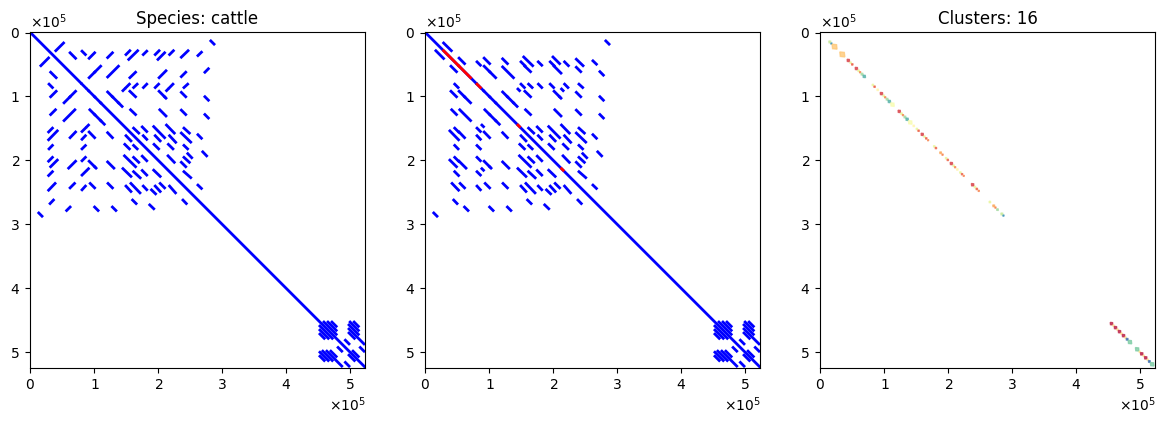

In [8]:
import utilx2
reload(utilx2)
from utilx2 import find_split_points_dbscan, split_segments_by_values, loop, make_fig, plot_necklace

make_fig(df4_v2, df6, df8, df10, res_dir, species_name)


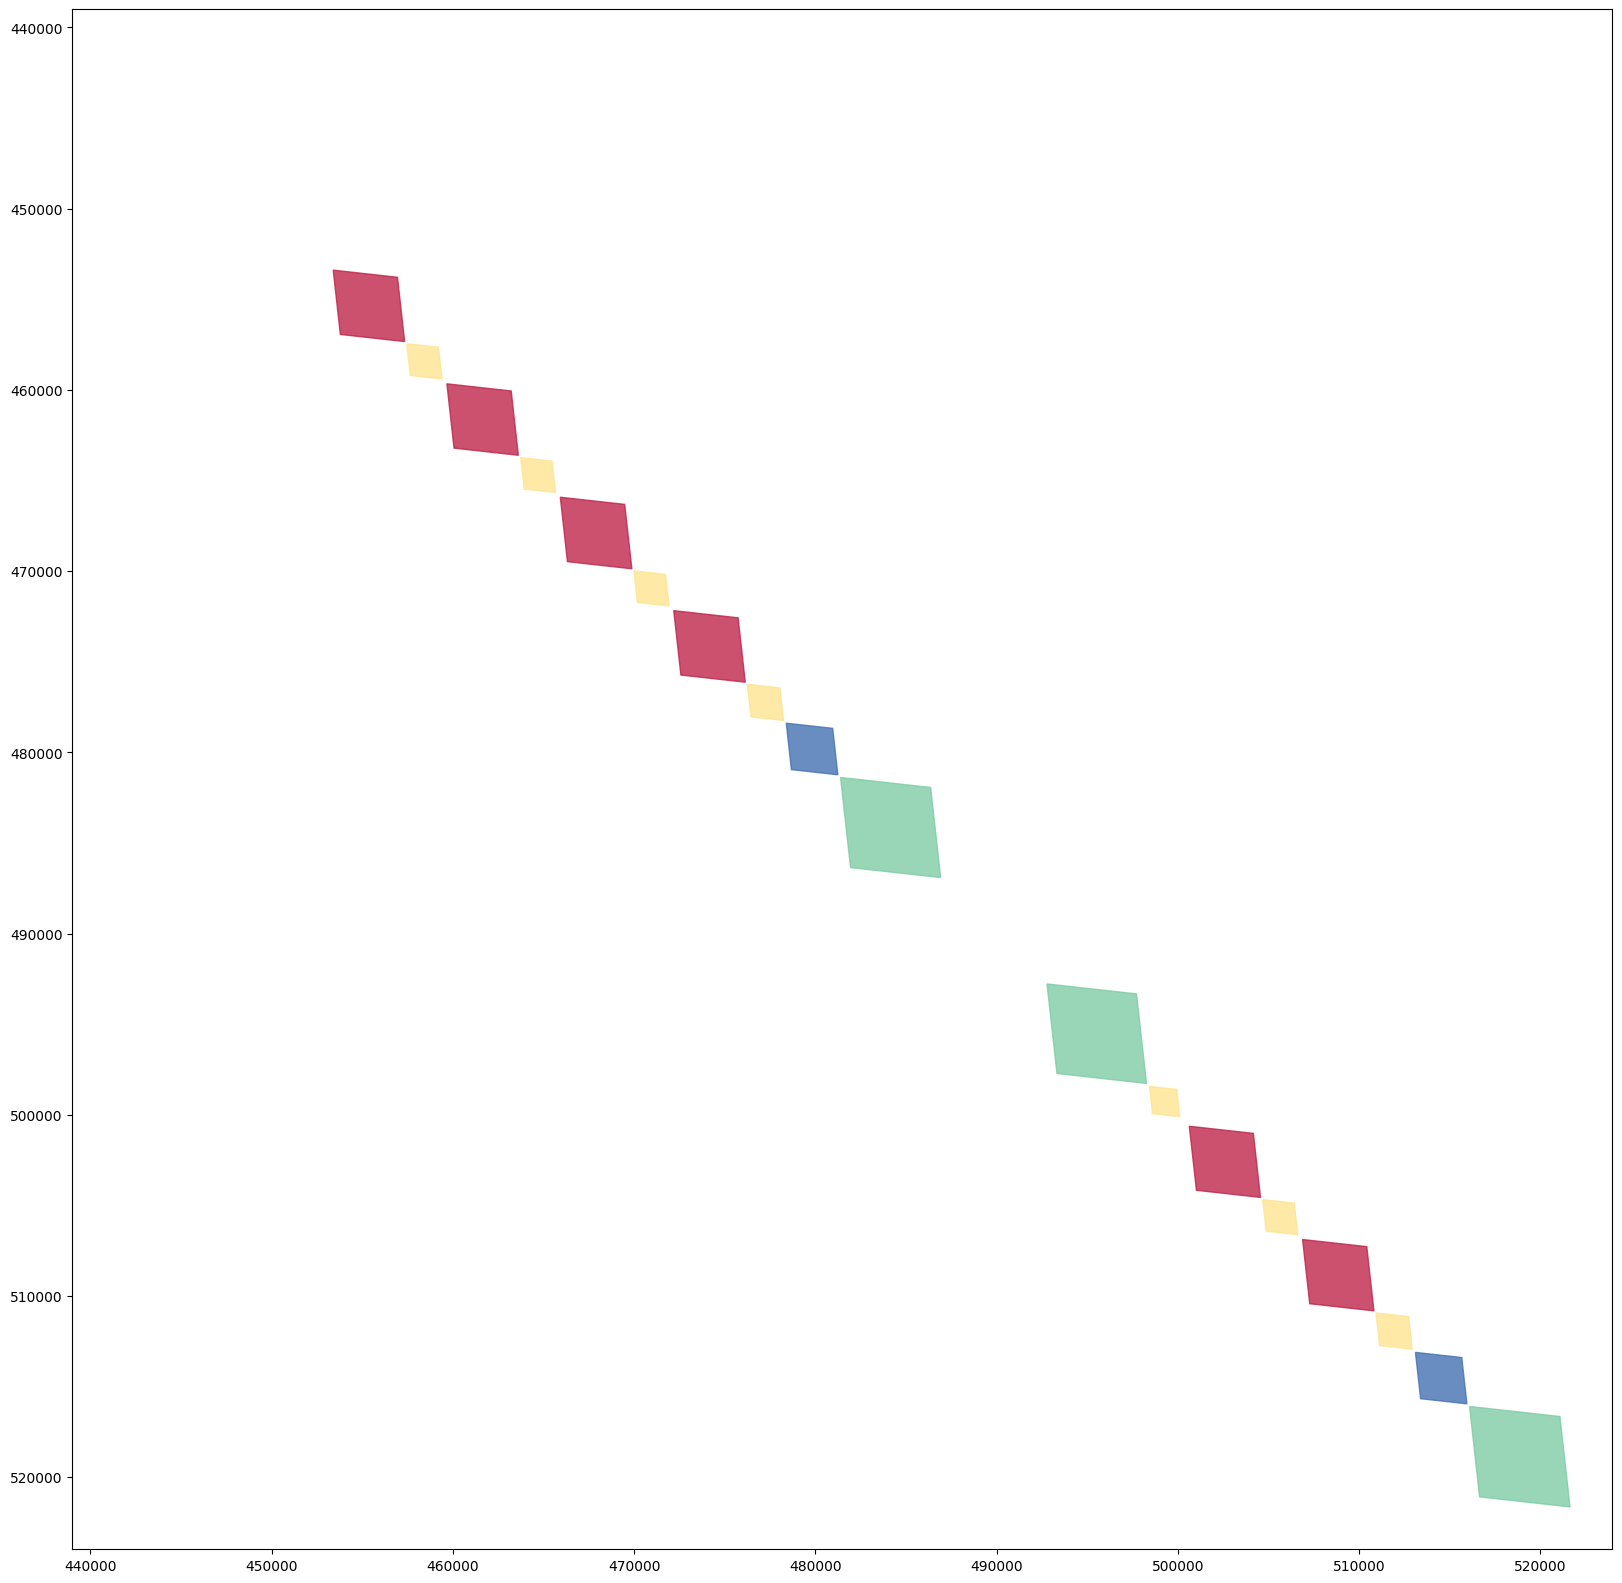

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))

colors = plot_necklace(ax, df8, s_min = 440000, e_max = df4_v2.x2.max())


In [10]:
print(dfw.head())
print(dfw.tail())

   seq_id       x1       x2        y1        y2 strand2     role
0       0      1.0  79190.0       1.0   79190.0       +  segment
1       1  13161.0  18172.0  282261.0  287267.0       +  segment
2      87  16433.0  28436.0   51872.0   39801.0       -  segment
3      88  28538.0  34477.0  223665.0  217714.0       -  segment
4      89  28538.0  34477.0  155547.0  149589.0       -  segment
     seq_id        x1        x2        y1        y2 strand2               role
295      82  498399.0  506762.0  469952.0  478345.0       +  segment_reflected
296      83  500134.0  513029.0  452897.0  465850.0       +  segment_reflected
297      84  504628.0  513029.0  498399.0  506762.0       +  segment_reflected
298      85  506371.0  513035.0  452897.0  459555.0       +  segment_reflected
299      86  515997.0  521773.0  492690.0  498401.0       +  segment_reflected


In [11]:
print(dfw_clusters.head())
print(dfw_clusters.tail())

  role            x1            x2  cluster reverse
0  NaN  13161.500000  16432.000000        1     NaN
1  NaN  16434.000000  18170.666667        2     NaN
2  NaN  18173.000000  26177.750000        3     NaN
3  NaN  30286.500000  38339.000000        3     NaN
4  NaN  41803.857143  45693.428571        5     NaN
              role        x1        x2  cluster reverse
75  reverse_region   28538.0   51872.0       -1    True
76  reverse_region   52734.0   70661.0       -1    True
77  reverse_region   80809.0   86056.0       -1    True
78  reverse_region  144797.0  147254.0       -1    True
79  reverse_region  213011.0  215446.0       -1    True
